In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

# 1. Wstępna analiza danych i czyszczenie

In [3]:
df_ = pd.read_csv('messy_data.csv')
df_

,carat,clarity,color,cut,x dimension,y dimension,z dimension,depth,table,price
0,0.50,IF,D,Ideal,5.1,5.15,3.2,61.5,,3000
1,0.70,vvs2,E,premium,5.7,,3.52,62,59,4500
2,NaN,Si2,h,Good,4.3,4.31,,62.3,56,700
3,1.20,if,d,ideal,,6.82,4.2,61.7,58,10000
4,0.90,I1,J,Fair,6,,3.7,61.7,,2400
...,...,...,...,...,...,...,...,...,...,...
195,0.45,si1,F,very good,4.9,4.89,,62.4,59,2300
196,1.25,VVS2,H,Good,6.9,,4.27,,55,10400
197,0.55,i1,I,Premium,5.3,,3.28,62.3,57,150000
198,0.85,Si2,E,fair,6.1,6.13,3.78,,58,6300


In [4]:
#Czyszczenie nazw kolumn i definiowanie typów danych
df = df_.copy()
new_column_names = {col: col.lstrip() if col.startswith(' ') else col for col in df.columns}
df.rename(columns=new_column_names, inplace=True)

#Podmianka white space'ów na nan
df = df.replace(r'^\s*$', np.nan, regex=True)

data_types = {
    'carat': np.float32,
    'clarity': 'category',
    'color': 'category',
    'cut': 'category',
    'x dimension': np.float32,
    'y dimension': np.float32,
    'z dimension': np.float32,
    'depth': np.float32,
    'table': np.float32,
    'price': np.float32
}
df = df.astype(data_types)

#Lowercase zmiennych kategorycznych
df[['clarity', 'color', 'cut']] = df[['clarity', 'color', 'cut']].applymap(lambda x: x.lower())

In [26]:
#Duplikaty
df[df.duplicated()]

#Brak w pełni zduplikowanych rekordów

,carat,clarity,color,cut,x dimension,y dimension,z dimension,depth,table,price


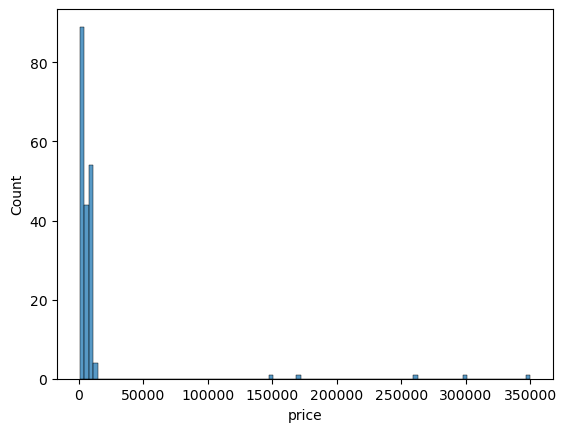

In [6]:
#Wartości odstające - rozkład zmiennej endogenicznej
sns.histplot(df['price'], bins=100)

#Bardzo duże outliery powyżej 50000 - usuwamy w celu lepszego dopasowania modelu
df = df.query('price < 50000').reset_index(drop = True)

In [7]:
#Spójność - analiza unikalnych wartości zmiennych kategorycznych
print("Clarity: ", df['clarity'].unique())
print("Color: ",df['color'].unique())
print("Cut: ",df['cut'].unique())

#Konieczne przeczyszczenie jak w nazwach kolumn

Clarity:  [' if' ' vvs2' ' si2' ' i1' ' si1' ' vvs1']
Color:  [' d' ' e' ' h' ' j' ' g' ' f' ' i' ' colorless']
Cut:  [' ideal' ' premium' ' good' ' fair' ' very good']


In [8]:
#Czyszczenie zmiennych kategorycznych
for col in ['clarity', 'color', 'cut']:
    df[col] = df[col].map(lambda x: x.lstrip() if x.startswith(' ') else x)

#Dużo lepiej :)
print("Clarity: ", df['clarity'].unique())
print("Color: ",df['color'].unique())
print("Cut: ",df['cut'].unique())

Clarity:  ['if' 'vvs2' 'si2' 'i1' 'si1' 'vvs1']
Color:  ['d' 'e' 'h' 'j' 'g' 'f' 'i' 'colorless']
Cut:  ['ideal' 'premium' 'good' 'fair' 'very good']


In [9]:
df

,carat,clarity,color,cut,x dimension,y dimension,z dimension,depth,table,price
0,0.50,if,d,ideal,5.1,5.15,3.20,61.500000,NaN,3000.0
1,0.70,vvs2,e,premium,5.7,NaN,3.52,62.000000,59.0,4500.0
2,NaN,si2,h,good,4.3,4.31,NaN,62.299999,56.0,700.0
3,1.20,if,d,ideal,NaN,6.82,4.20,61.700001,58.0,10000.0
4,0.90,i1,j,fair,6.0,NaN,3.70,61.700001,NaN,2400.0
...,...,...,...,...,...,...,...,...,...,...
186,0.95,si1,g,ideal,6.4,6.42,3.96,NaN,56.0,7100.0
187,0.45,si1,f,very good,4.9,4.89,NaN,62.400002,59.0,2300.0
188,1.25,vvs2,h,good,6.9,NaN,4.27,NaN,55.0,10400.0
189,0.85,si2,e,fair,6.1,6.13,3.78,NaN,58.0,6300.0


In [11]:
#Sprawdzenie liczby rekordów z brakami danych
print(df.isna().sum())
df[df.isnull().any(axis=1)]

carat          46
clarity         0
color           0
cut             0
x dimension     2
y dimension    60
z dimension    46
depth          65
table          32
price           0
dtype: int64


,carat,clarity,color,cut,x dimension,y dimension,z dimension,depth,table,price
0,0.50,if,d,ideal,5.1,5.15,3.20,61.500000,NaN,3000.0
1,0.70,vvs2,e,premium,5.7,NaN,3.52,62.000000,59.0,4500.0
2,NaN,si2,h,good,4.3,4.31,NaN,62.299999,56.0,700.0
3,1.20,if,d,ideal,NaN,6.82,4.20,61.700001,58.0,10000.0
4,0.90,i1,j,fair,6.0,NaN,3.70,61.700001,NaN,2400.0
...,...,...,...,...,...,...,...,...,...,...
186,0.95,si1,g,ideal,6.4,6.42,3.96,NaN,56.0,7100.0
187,0.45,si1,f,very good,4.9,4.89,NaN,62.400002,59.0,2300.0
188,1.25,vvs2,h,good,6.9,NaN,4.27,NaN,55.0,10400.0
189,0.85,si2,e,fair,6.1,6.13,3.78,NaN,58.0,6300.0


In [12]:
# Braki danych wydają się wstępować losowo - inputujemy z KNN (z uwagi na małą liczbę rekorów nie chcę usuwać)
imput_columns = ['carat', 'x dimension', 'y dimension', 'z dimension', 'depth', 'table']
df_imput = df[imput_columns]
df_rest = df.drop(imput_columns, axis=1)

imputer = KNNImputer(n_neighbors=3)

imput_knn = pd.DataFrame(imputer.fit_transform(df_imput)
                         .round(2), 
                         columns=df_imput.columns)

# Skala wartości - przeskalowanie danych numerycznych za pomocą Min Max scalera
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(imput_knn).round(2), columns=imput_columns)

df_final = pd.concat([df_scaled, df_rest], axis=1)
df_final

,carat,x dimension,y dimension,z dimension,depth,table,clarity,color,cut,price
0,0.21,0.35,0.37,0.38,0.17,0.50,if,d,ideal,3000.0
1,0.36,0.53,0.56,0.53,0.44,0.83,vvs2,e,premium,4500.0
2,0.11,0.12,0.12,0.21,0.61,0.33,si2,h,good,700.0
3,0.71,0.85,0.86,0.86,0.28,0.67,if,d,ideal,10000.0
4,0.50,0.62,0.63,0.62,0.28,0.39,i1,j,fair,2400.0
...,...,...,...,...,...,...,...,...,...,...
186,0.54,0.74,0.75,0.74,0.68,0.33,si1,g,ideal,7100.0
187,0.18,0.29,0.29,0.27,0.67,0.83,si1,f,very good,2300.0
188,0.75,0.88,0.86,0.89,0.74,0.17,vvs2,h,good,10400.0
189,0.46,0.65,0.66,0.66,0.44,0.67,si2,e,fair,6300.0


# 2. Wizualizacja rozkładu zmiennych, zależności ceny od innych zmiennych, liczebność kategorii

In [13]:
numeric_columns = ['carat', 'x dimension', 'y dimension', 'z dimension', 'depth', 'table']
categorical_columns = ['clarity', 'color', 'cut']
dependent_variable = 'price'

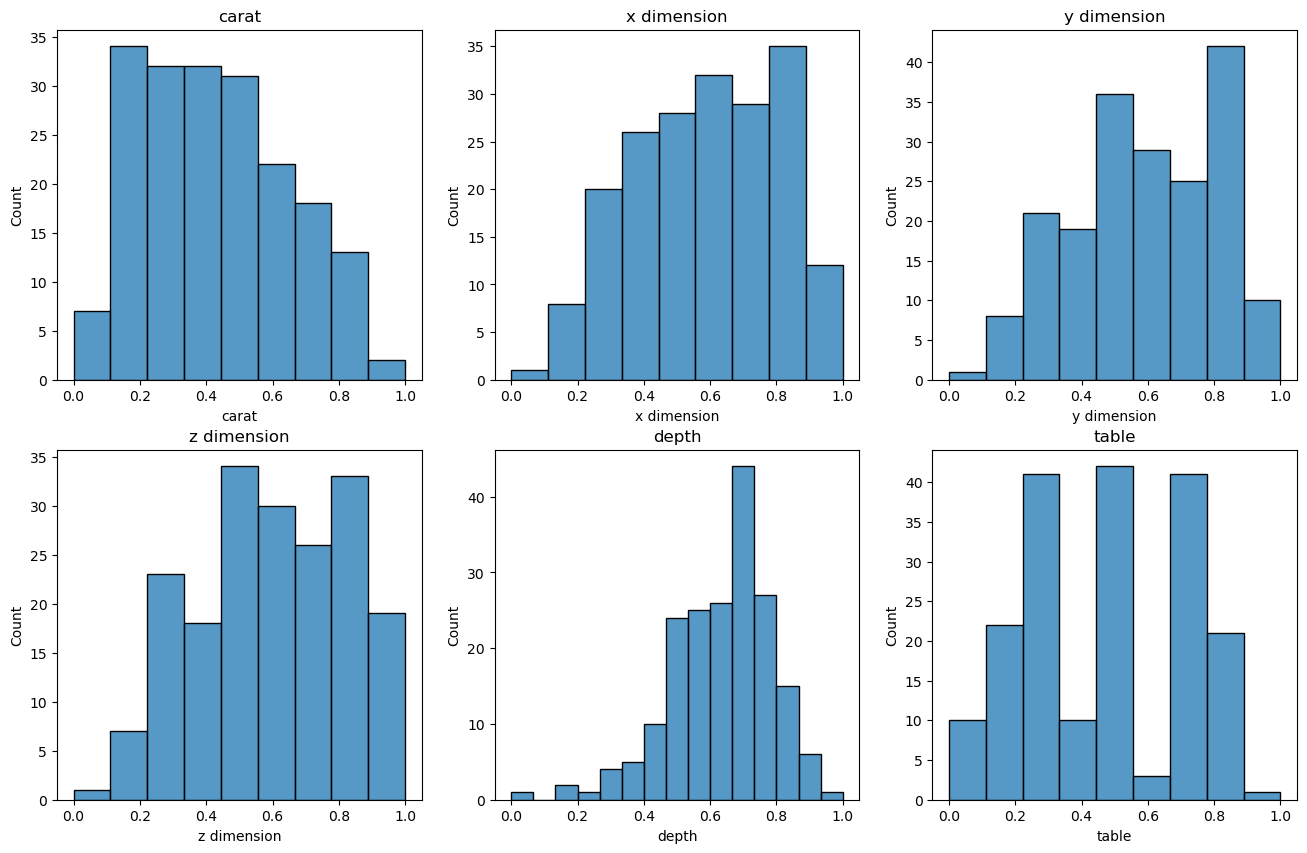

In [14]:
# Wizualizacja rozkładu zmiennych numerycznych
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for i, ax in enumerate(axes.flatten()):
    sns.histplot(df_final[numeric_columns[i]], ax=ax)
    ax.set_title(numeric_columns[i])

# Rozkłady bez większych anomalii

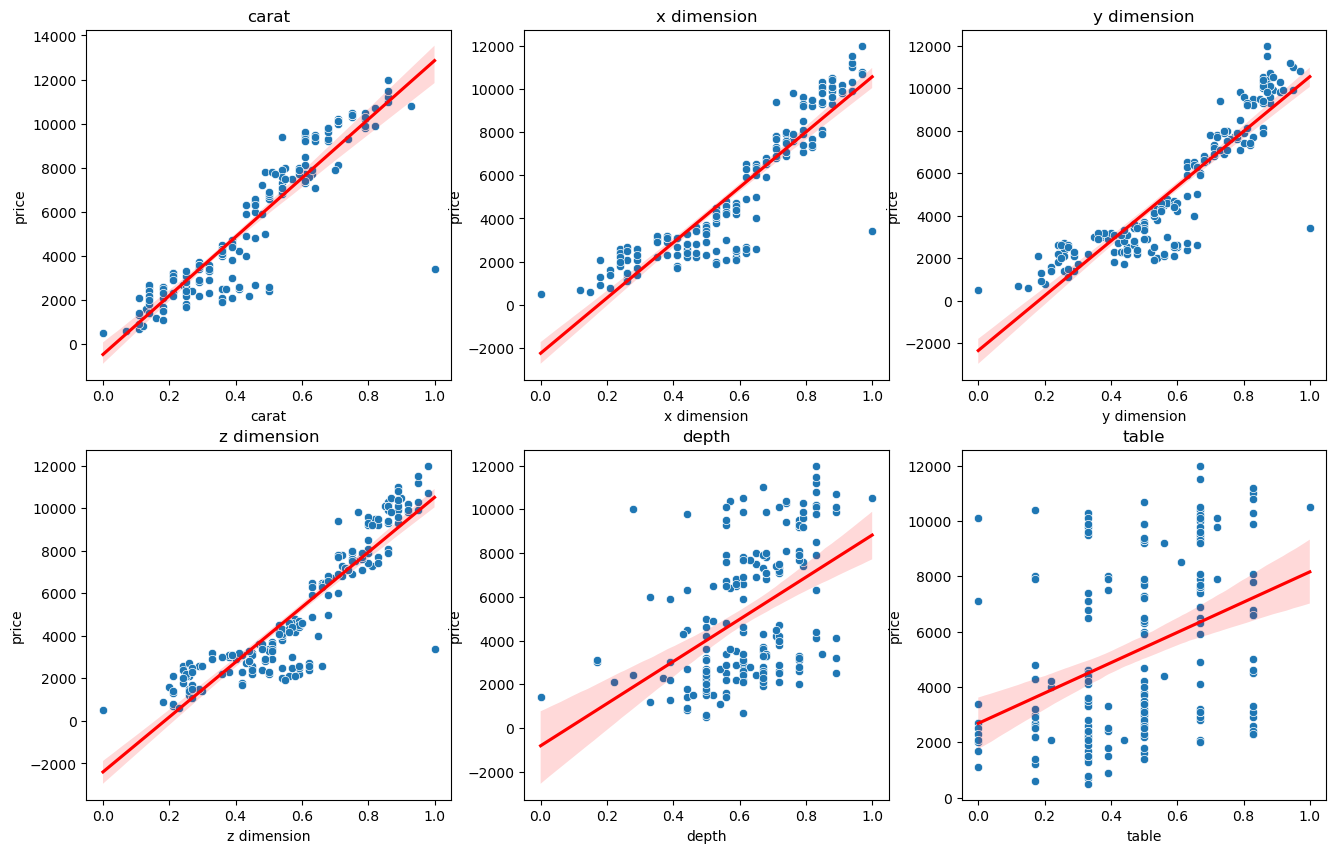

In [15]:
# Zależności ceny od innych zmiennych
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for i, ax in enumerate(axes.flatten()):
    sns.scatterplot(x=numeric_columns[i], y=dependent_variable, data=df_final, ax=ax)
    sns.regplot(x=numeric_columns[i], y=dependent_variable, data=df_final, ax=ax, scatter=False, color='red')
    ax.set_title(numeric_columns[i])

# Występuje liniowa relacja pomiędzy zmiennymi numerycznymi a zmienną objaśnianą

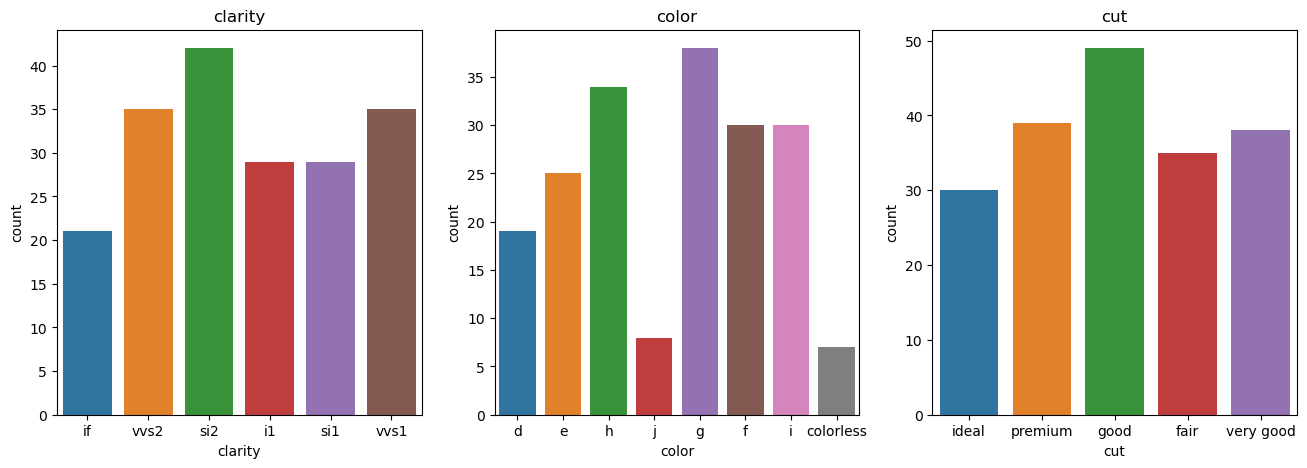

In [16]:
# Liczebność kategorii
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i, ax in enumerate(axes.flatten()):
    sns.countplot(x=categorical_columns[i], data=df_final, ax=ax)
    ax.set_title(categorical_columns[i])

# Kategorie zróżnicowane - nie ma potrzeby łączenia

# 3. Budowa modelu regresji ceny od pozostałych zmiennych. Istotne zmienne należy wybrać eliminacją wsteczną lub selekcją postępującą.

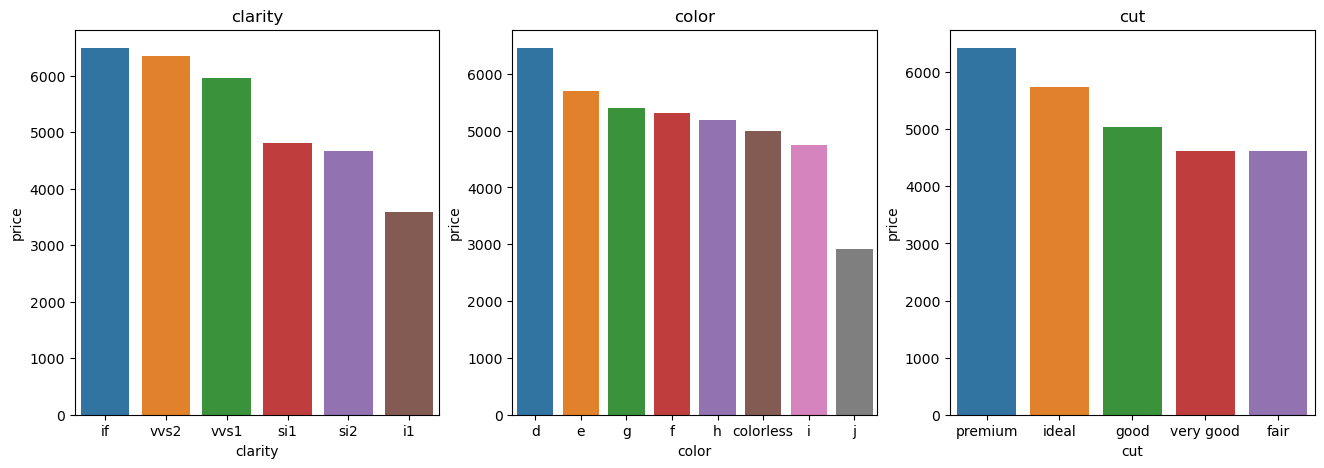

In [17]:
# Transformacja zmiennych kategorycznych na numeryczne do modelowania
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i, ax in enumerate(axes.flatten()):
    df_gb = (df_final
             .groupby(categorical_columns[i])
             .agg({'price': 'mean'}).reset_index()
             .sort_values(by='price', ascending=False))
    sns.barplot(x=categorical_columns[i], y ='price', data=df_gb, ax=ax)
    ax.set_title(categorical_columns[i])


In [18]:
# Kategorie wyraźnie różnią się ceną - wobec tego zastosowany zostanie label encoding
df_model = df_final.copy()
# Definiowanie kolejności kategorii
clarity_order = {'if': 5, 'vvs2': 4, 'vvs1': 3, 'si1': 2, 'si2': 1, 'i1': 0}
color_order = {'d': 7, 'e': 6, 'g': 5, 'f': 4, 'h': 3, 'colorless': 2,  'i': 1, 'j': 0}

#Mimo, że good na wykresie ma wyższą średnią cenę niż very good to z uwagi na zdrowy rozsądek ma przypisaną niższą wartość.
cur_order = {'premium': 4, 'ideal': 3, 'very good': 2, 'good': 1, 'fair': 0}

# le = LabelEncoder()
df_model['clarity'] = df_model['clarity'].map(clarity_order)
df_model['color'] = df_model['color'].map(color_order)
df_model['cut'] = df_model['cut'].map(cur_order)
df_model

,carat,x dimension,y dimension,z dimension,depth,table,clarity,color,cut,price
0,0.21,0.35,0.37,0.38,0.17,0.50,5,7,3,3000.0
1,0.36,0.53,0.56,0.53,0.44,0.83,4,6,4,4500.0
2,0.11,0.12,0.12,0.21,0.61,0.33,1,3,1,700.0
3,0.71,0.85,0.86,0.86,0.28,0.67,5,7,3,10000.0
4,0.50,0.62,0.63,0.62,0.28,0.39,0,0,0,2400.0
...,...,...,...,...,...,...,...,...,...,...
186,0.54,0.74,0.75,0.74,0.68,0.33,2,5,3,7100.0
187,0.18,0.29,0.29,0.27,0.67,0.83,2,4,2,2300.0
188,0.75,0.88,0.86,0.89,0.74,0.17,4,3,1,10400.0
189,0.46,0.65,0.66,0.66,0.44,0.67,1,6,0,6300.0


In [19]:
df_model = sm.add_constant(df_model)
model = sm.OLS(df_model['price'], df_model.drop(columns=['price'])).fit()

In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     191.9
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           1.22e-87
Time:                        14:18:51   Log-Likelihood:                -1582.3
No. Observations:                 191   AIC:                             3185.
Df Residuals:                     181   BIC:                             3217.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2969.3479    431.700     -6.878      0.000   -3821.160   -2117.536
carat        9547.0842   1710.349      5.582      0.000    6172.297    1.29e+04
x dimension  1334.8103   6394.376      0.209      0.835   -1.13e+04     1.4e+04
y dimension -3510.3556   4385.855     -0.800      0.425   -1.22e+04    5143.625
z dimension  4766.8801   4281.893      1.113      0.267   -3681.967    1.32e+04
depth        1284.4887    552.299      2.326      0.021     194.717    2374.261
table         826.5108    361.206      2.288      0.023     113.795    1539.226
clarity       342.1884     47.468      7.209      0.000     248.526     435.851
color          59.8283     37.751      1.585      0.115     -14.661     134.317
cut           179.3814     54.808      3.273      0.001      71.237     287.526
==============================================================================
Omnibus:                      119.663   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1453.514
Skew:                          -2.103   Prob(JB):                         0.00
Kurtosis:                      15.843   Cond. No.                         599.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Przy poziomie istotności 5%, zmienne y dimension, z dimension oraz color są nieistotne statystycznie

In [21]:
# Eliminacja wsteczna - modelowanie bez nieistotnych zmiennych
df_model_2 = df_model.drop(columns=['z dimension', 'y dimension', 'color'])
model_2 = sm.OLS(df_model_2['price'], df_model_2.drop(columns=['price'])).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     285.4
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           2.23e-90
Time:                        14:18:51   Log-Likelihood:                -1584.5
No. Observations:                 191   AIC:                             3183.
Df Residuals:                     184   BIC:                             3206.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2710.9952    406.357     -6.671      0.000   -3512.713   -1909.278
carat        9667.1572   1685.542      5.735      0.000    6341.683     1.3e+04
x dimension  2574.5560   1642.239      1.568      0.119    -665.483    5814.595
depth        1102.0563    539.000      2.045      0.042      38.642    2165.470
table         866.2474    360.664      2.402      0.017     154.679    1577.816
clarity       350.1995     46.364      7.553      0.000     258.727     441.672
cut           193.8285     54.379      3.564      0.000      86.541     301.116
==============================================================================
Omnibus:                      121.732   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1570.372
Skew:                          -2.129   Prob(JB):                         0.00
Kurtosis:                      16.386   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Wyniki modelu nie uległy zmianie - skorygowany R kwadrat na takim samym poziomie

# 4. Wizualizacja modelu regresji

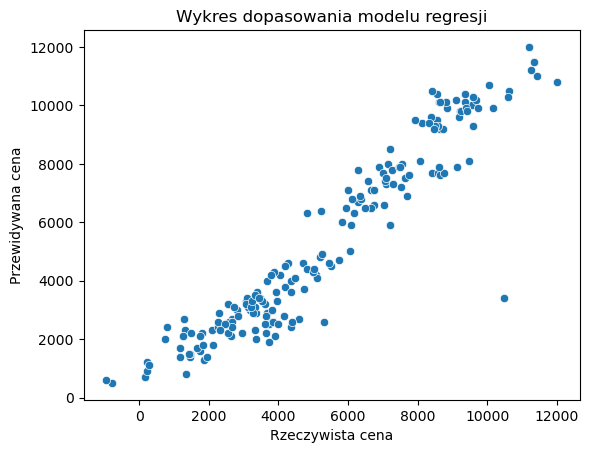

In [22]:
# Dopasowanie modelu
pred = model_2.predict(df_model_2.drop(columns=['price']))

sns.scatterplot(x=pred, y=df_model_2['price'])
plt.xlabel('Rzeczywista cena')
plt.ylabel('Przewidywana cena')
plt.title('Wykres dopasowania modelu regresji')
plt.show()

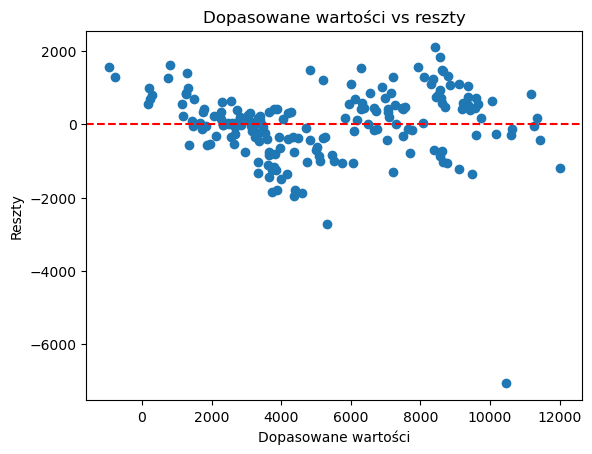

In [23]:
# Heteroskedastryczność
residuals = model_2.resid
plt.scatter(model_2.fittedvalues, residuals)
plt.xlabel('Dopasowane wartości')
plt.ylabel('Reszty')
plt.title('Dopasowane wartości vs reszty')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Błędy występują losowo - brak heteroskedastryczności

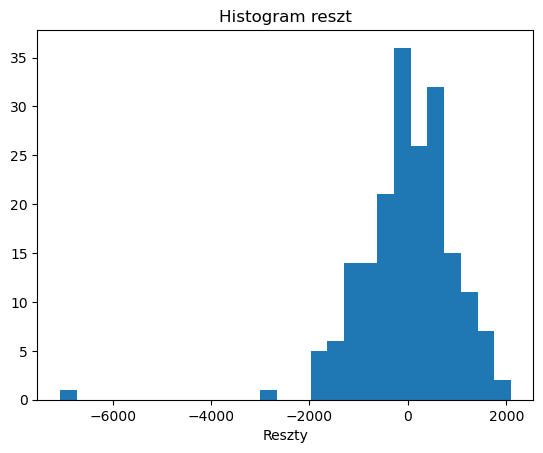

In [24]:
# Rozkład reszt modelu
plt.hist(residuals, bins='auto')
plt.xlabel('Reszty')
plt.ylabel('')
plt.title('Histogram reszt')
plt.show()

# Reszty mają rozkład zbliżony do normalnego

In [25]:
# Zapisanie danych do dashboardu - zapisujemy dane wyczyszczone, ale bez skalowania
df.to_csv('clean_data.csv', index=False)